In [ ]:
import pandas as pd
import regex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from google.colab import files
uploaded = files.upload()

from IPython.display import Image
Image("img/picture.png")


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['500_Cities_Data.csv']))
#This dataset has three different measurements for each variable.
#We only want crude estimates, so we will drop others.

In [40]:
df = df[df.columns.drop(list(df.filter(regex='95')))]
df = df[df.columns.drop(list(df.filter(regex='AdjPrev')))]

for cols in df.columns:
    print(cols)

StateAbbr
PlaceName
PlaceFIPS
Population2010
ACCESS2_CrudePrev
ARTHRITIS_CrudePrev
BINGE_CrudePrev
BPHIGH_CrudePrev
BPMED_CrudePrev
CANCER_CrudePrev
CASTHMA_CrudePrev
CHD_CrudePrev
CHECKUP_CrudePrev
CHOLSCREEN_CrudePrev
COLON_SCREEN_CrudePrev
COPD_CrudePrev
COREM_CrudePrev
COREW_CrudePrev
CSMOKING_CrudePrev
DENTAL_CrudePrev
DIABETES_CrudePrev
HIGHCHOL_CrudePrev
KIDNEY_CrudePrev
LPA_CrudePrev
MAMMOUSE_CrudePrev
MHLTH_CrudePrev
OBESITY_CrudePrev
PAPTEST_CrudePrev
PHLTH_CrudePrev
SLEEP_CrudePrev
STROKE_CrudePrev
TEETHLOST_CrudePrev
Geolocation


In [0]:
#Drop string and location columns 
df = df.drop(columns = ['PlaceName', 'Geolocation', 'PlaceFIPS', 'StateAbbr'], axis =1)

count    500.000000
mean      15.453800
std        6.268764
min        4.200000
25%       11.100000
50%       14.100000
75%       18.700000
max       43.800000
Name: ACCESS2_CrudePrev, dtype: float64


(array([ 41., 124., 140.,  97.,  52.,  26.,   9.,   4.,   3.,   4.]),
 array([ 4.2 ,  8.16, 12.12, 16.08, 20.04, 24.  , 27.96, 31.92, 35.88,
        39.84, 43.8 ]),
 <a list of 10 Patch objects>)

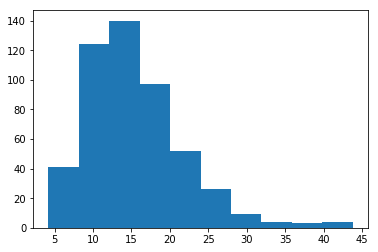

In [42]:
#Let's take a quick look at our target variable: the percent of a city that does not have access to healthcare
print(df.ACCESS2_CrudePrev.describe())
y_var = df.ACCESS2_CrudePrev
plt.hist(y_var)
#it is slightly skewed, but a Guassian distribution is not an assumption.

Population2010
ACCESS2_CrudePrev
ARTHRITIS_CrudePrev
BINGE_CrudePrev
BPHIGH_CrudePrev
BPMED_CrudePrev
CANCER_CrudePrev
CASTHMA_CrudePrev
CHD_CrudePrev
CHECKUP_CrudePrev
CHOLSCREEN_CrudePrev
COLON_SCREEN_CrudePrev
COPD_CrudePrev
COREM_CrudePrev
COREW_CrudePrev
CSMOKING_CrudePrev
DENTAL_CrudePrev
DIABETES_CrudePrev
HIGHCHOL_CrudePrev
KIDNEY_CrudePrev
LPA_CrudePrev
MAMMOUSE_CrudePrev
MHLTH_CrudePrev
OBESITY_CrudePrev
PAPTEST_CrudePrev
PHLTH_CrudePrev
SLEEP_CrudePrev
STROKE_CrudePrev
TEETHLOST_CrudePrev


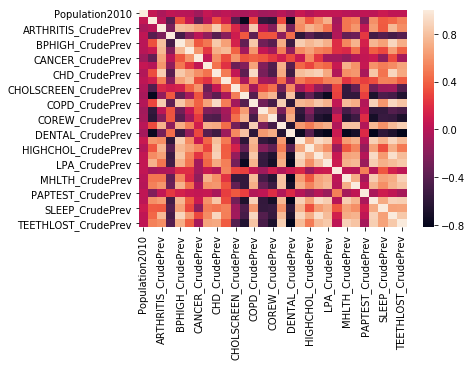

In [43]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
#Lots of variables that correlate here due to comorbidity
#We will drop all columns that highly correlate
for cols in df.columns:
    print(cols)
#sns.heatmap

In [0]:
#Drop highly correlated features
df = df.drop(columns = ['CHD_CrudePrev', 'ARTHRITIS_CrudePrev',
                        'BPHIGH_CrudePrev', 'COPD_CrudePrev',
                        'LPA_CrudePrev', 'KIDNEY_CrudePrev',
                        'TEETHLOST_CrudePrev', 'CSMOKING_CrudePrev',
                        'OBESITY_CrudePrev','PHLTH_CrudePrev','MHLTH_CrudePrev',
                        'STROKE_CrudePrev', 'DIABETES_CrudePrev', 'DENTAL_CrudePrev',
                        'BPMED_CrudePrev', 'PAPTEST_CrudePrev', 'CANCER_CrudePrev',
                        'SLEEP_CrudePrev', 'CHECKUP_CrudePrev'])

In [0]:
#Screenings are an important variable, let's combine the two features separated by gender
df['CORE_AVG'] = (df['COREM_CrudePrev'] + df['COREW_CrudePrev']) / 2
df = df.drop(columns = ['COREM_CrudePrev', 'COREW_CrudePrev', 'COLON_SCREEN_CrudePrev'])

In [0]:
#Population is on a different scale from everything else, let's tranform
#Let's transform it to be closer to other features
df['Population2010'] = np.log(df['Population2010'])

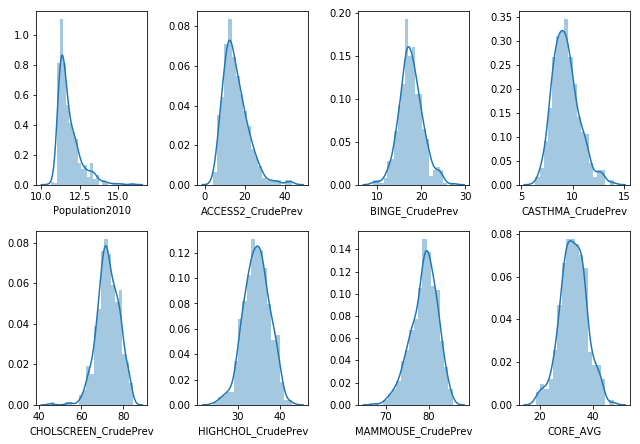

In [47]:
#plot features we have left
plt.figure(figsize=(9,15))
i = 1
for column in df.columns:
    plt.subplot(5,4,i)
    sns.distplot(df[column])
    i+=1
plt.tight_layout()
plt.show()

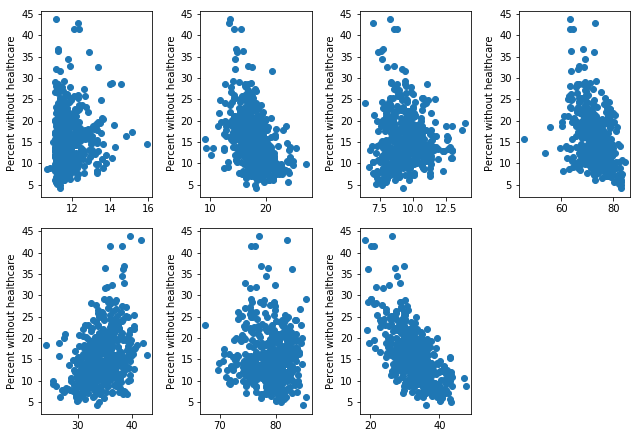

In [48]:
#Drop target variable and plot bivariate relationship
df = df.drop(columns =['ACCESS2_CrudePrev'])
plt.figure(figsize=(9,15))
i = 1
for column in df.columns:
    plt.subplot(5,4,i)
    plt.scatter(df[column], y_var)
    plt.ylabel('Percent without healthcare')
    i+=1
plt.tight_layout()
plt.show()

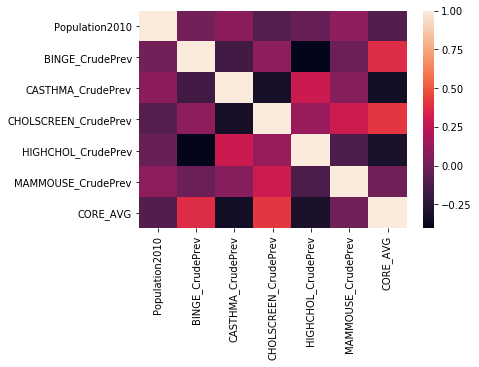

In [49]:
#Check new correlation matrix after dropping features
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
#Much better!

In [0]:
#Use (15%) as the dividing line for low-risk to access and high-risk to access
y_var = np.array(y_var)
y_var[y_var <= 15 ] = 0
y_var[y_var > 15] = 1

The value "0" represents a city whose inhabitants have 85% or more covered under health insurance, and the value "1" represents the counts of cities who have fewer than 85% of its inhabitants covered.

Out of 500 cities, 226 have 15% or more lacking health insurance.


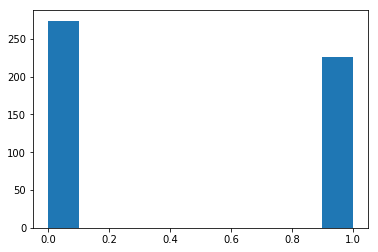

In [51]:
#Use histogram to check for class imbalance
plt.hist(y_var)
#High-risk access is slightly the minority class but not by much
print('Out of 500 cities, ' + str(np.count_nonzero(y_var)) + ' have 15% or more lacking health insurance.')

In [52]:
#Run as logistic regression since we made this a classification problem
X = df
lr = LogisticRegression(C=1e9)

X_train, X_test, y_train, y_test = train_test_split(X,y_var, test_size = .3)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('Logistic regression training accuracy score: ', round(lr.score(X_train, y_train), 3))
print('Logistic regression test accuracy score: ', round(lr.score(X_test, y_test), 3))

[[71 10]
 [13 56]]
Logistic regression training accuracy score:  0.809
Logistic regression test accuracy score:  0.847


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
from sklearn.model_selection import cross_val_score
#test cross validation
cross_val_score(lr, X, y_var, cv=3)
#slightly outperforms

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.78571429, 0.8253012 , 0.79518072])


Polarizing the target variable at 15% is kind of abitrary and we lose information in the process. Let's use a decision tree and random forest to test if we can successfully estimate the percentage of a city's population that does not have coverage.

In [54]:
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

decision_tree = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_features = 1,
        max_depth =3
)
decision_tree.fit(X, y_var)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

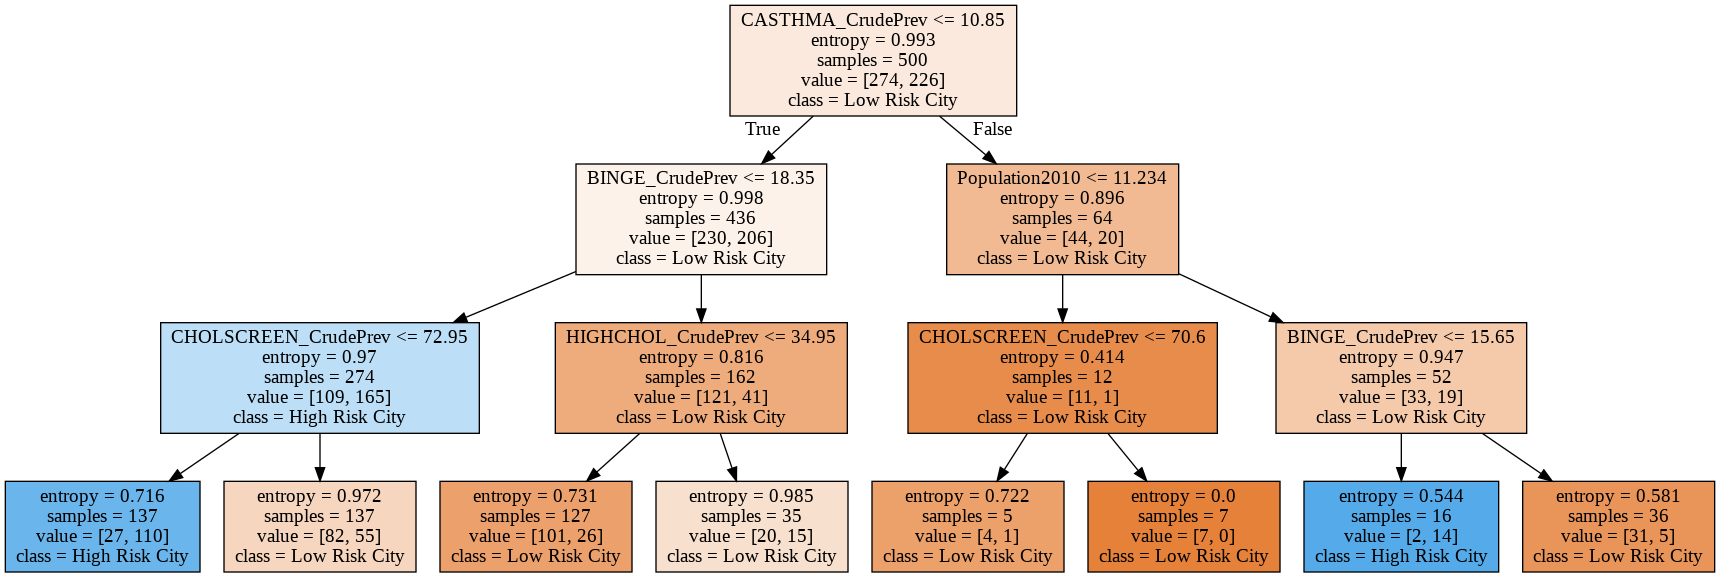

In [58]:
#Visualize tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Low Risk City', 'High Risk City'],
    filled = True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [89]:
cross_val_score(decision_tree, X, y_var, cv=3)

array([0.64285714, 0.68072289, 0.62650602])

In [119]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, y_var, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.76190476, 0.75301205, 0.75301205])

In [0]:
#Can we use boosting to improve on these models?
#Deviance used for logistic regression
#Use the same depth as the previous model for consistency
param_grid = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}
boost = ensemble.GradientBoostingClassifier(**param_grid)
boost.fit(X_train, y_train)

predict_train = boost.predict(X_train)
predict_test = boost.predict(X_test)
cross_val_score(boost, X, y_var, cv=3)

In [113]:
#Find best parameters for models
from sklearn.model_selection import GridSearchCV

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
parameters = dict(C=C, penalty=penalty)

gslr = GridSearchCV(lr, parameters, cv =3)
results = gslr.fit(X_train, y_train)

print('Best penalty:', results.best_estimator_.get_params()['penalty'])
print('Best score:', results.best_score_)
gslr_output = results.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best penalty: l1
Best score: 0.8028571428571428


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

In [115]:
#Find best parameters for random forest
criterion = ['entropy', 'gini']
n_estimators = np.arange(200, 600, 20)
max_depth = np.arange(2, 8, 1)
hyperparameters = dict(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth
)
clf = GridSearchCV(rfc, hyperparameters, cv =3)

results = clf.fit(X_train, y_train)

print('Best Criterion:', results.best_estimator_.get_params()['criterion'])
print('Best n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Optimum Depth:', results.best_estimator_.get_params()['max_depth'])
print('Best Score:', results.best_score_)

gsrfc_output = results.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Criterion: entropy
Best n estimators: 200
Optimum Depth: 7
Best Score: 0.7857142857142857


In [0]:
#Store scores from models
rfc_output = (cross_val_score(rfc, X, y_var, cv=3)) / 3

output = pd.DataFrame()
output['Logistic Regression Original Score'] = lr.score
output['Logistic Regression GridSearch Score'] = gslr_output
output['Random Forest Original Score'] = rfc_output
output['Random Forest GridSearch Score'] = gsrfc_output



In [1]:
print(output.head(5))

NameError: name 'output' is not defined